# Financial Datasets For Fraud Detection

This synthetic dataset is scaled down 1/4 of the original dataset. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world. Dataset is based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country.

[Dataset](https://www.kaggle.com/ntnu-testimon/paysim1) taken from the Kaggle

Headers Description:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time.

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [2]:
import numpy as np
seed = 42
np.random.seed(seed)

import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt 
import time

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier
from lightgbm.sklearn import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import precision_score, accuracy_score, f1_score
from sklearn.metrics import average_precision_score, recall_score , matthews_corrcoef

In [ ]:
df = pd.read_csv('/content/drive/My Drive/archive (1).zip')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
fraud = df[df.isFraud == 1]
not_fraud = df[df.isFraud == 0]
flagged_fraud = fraud[fraud.isFlaggedFraud == 1]

In [ ]:
print('Does the Dataframe have Nan?:', df.isnull().values.any())

Does the Dataframe have Nan?: False


In [ ]:
df.groupby(['type', 'isFraud', 'isFlaggedFraud']).count()['step']

type      isFraud  isFlaggedFraud
CASH_IN   0        0                 1399284
CASH_OUT  0        0                 2233384
          1        0                    4116
DEBIT     0        0                   41432
PAYMENT   0        0                 2151495
TRANSFER  0        0                  528812
          1        0                    4081
                   1                      16
Name: step, dtype: int64

In [ ]:
print('Fraud percentage:', len(fraud)/len(not_fraud) * 100)
print('Percentage of FlaggedFraud:', len(flagged_fraud)/len(df) * 100)
print('Total FlaggedFraud:', len(flagged_fraud))

Fraud percentage: 0.129248881917699
Percentage of FlaggedFraud: 0.000251468734577894
Total FlaggedFraud: 16


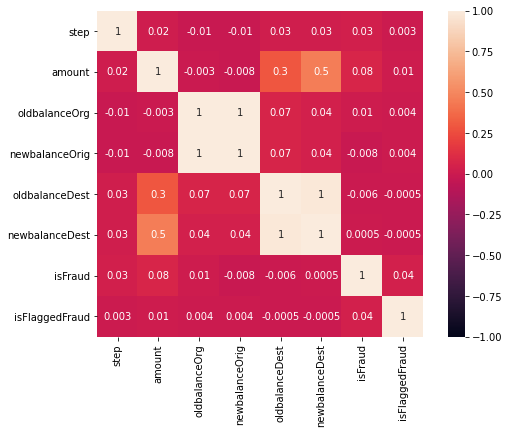

In [ ]:
c_matrix = df.corr()
plt.figure(figsize = (9, 6)) 
sns.heatmap(c_matrix, vmin=-1, annot=True, fmt='.1g', square=True) 
plt.show()

In [ ]:
print('number of transfers with amount of money more than 200000:', len(fraud[(fraud.amount > 200000) & (fraud.type == 'TRANSFER')]))

number of transfers with amount of money more than 200000: 2740


Based on the description, it can be seen that FlaggedFraud should have been marked in more cases. It also looks like FlaggedFraud is not associated with any of the dependent variables. And it has an extremely low percentage of observations.
Therefore, I assume  that I can remove FlaggedFraud from the dataset without losing information. (переписать)

In [ ]:
print(*fraud.type.unique())
print('number of fraudulent transfers:', len(fraud[fraud.type == 'TRANSFER']))
print('number of fraudulent cashouts:', len(fraud[fraud.type == 'CASH_OUT']))

TRANSFER CASH_OUT
number of fraudulent transfers: 4097
number of fraudulent cashouts: 4116


In this dataset the fraudulent behavior aims to make a transfer to a fraudulent account with the subsequent execution of a cashout. So, I assume that a fraud only happens when the transaction type is 'TRANSFER' or 'CASH_OUT'. This is confirmed above. We can also see that the number of transfers and cashouts is approximately the same. Let's check if this means that the fraudulent account makes a transfer first and then a cashout.


In [ ]:
new_df = df[(df.type == 'CASH_OUT') | (df.type == 'TRANSFER')].drop('isFlaggedFraud', axis=1)
fraud = new_df[new_df.isFraud == 1]
new_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,C1305486145,181.0,0.0,C553264065,0.0,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.0,C38997010,21182.0,0.00,1
15,1,CASH_OUT,229133.94,C905080434,15325.0,0.0,C476402209,5083.0,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.0,0.0,C1100439041,22425.0,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.0,0.0,C932583850,6267.0,2719172.89,0


In [ ]:
fraud[fraud.type == 'TRANSFER'].nameOrig.isin(fraud[fraud.type == 'CASH_OUT'].nameDest).value_counts()

False    4097
Name: nameOrig, dtype: int64

As displayed above, there were no accounts that made the transfer and then the cashout. So, I assume there is no correlation between the accounts from which the transfer was made and the accounts from which the money was withdrawn as a result of fraud.
Thus, the nameOrig and the nameDest are also removed from the dataset.

In [ ]:
new_df = new_df.drop(['nameOrig', 'nameDest'], axis=1)

Looking at the data, you can see a zero value in the oldbalanceOrg and the 
newbalanceOrig, however the amount field has a non-zero value. The same is true for the oldbalanceDest and the newbalanceDest. I assume that the unknown data was initially replaced with "0", but since zero balance can be a considerable fraud factor, I'm going to replaced ​​with "-1".
Errors in the account balance data are also clearly visible in the process of performing transactions, on this basis we are creating two new features containing these errors.



In [ ]:
new_df.loc[((new_df.oldbalanceOrg	== 0)
        & (new_df.newbalanceOrig == 0)
        & (new_df.amount != 0)), ['oldbalanceOrg',	'newbalanceOrig']] = -1
new_df.loc[((new_df.oldbalanceDest	== 0)
        & (new_df.newbalanceDest == 0)
        & (new_df.amount != 0)), ['oldbalanceDest',	'newbalanceDest']] = -1
        
new_df['errbalanceOrg'] = new_df.amount - new_df.oldbalanceOrg + new_df.newbalanceOrig
new_df['errbalanceDest'] = new_df.amount + new_df.oldbalanceDest - new_df.newbalanceDest

fraud = new_df[new_df.isFraud == 1]
not_fraud = new_df[new_df.isFraud == 0]
new_df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errbalanceOrg,errbalanceDest
2,1,TRANSFER,181.00,181.0,0.0,-1.0,-1.00,1,0.00,181.0
3,1,CASH_OUT,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0
15,1,CASH_OUT,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5
19,1,TRANSFER,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3
24,1,TRANSFER,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0


Let's look at the distribution of transactions over time and visualize whether our features can separate transactions into fraudulent and valid successfully.


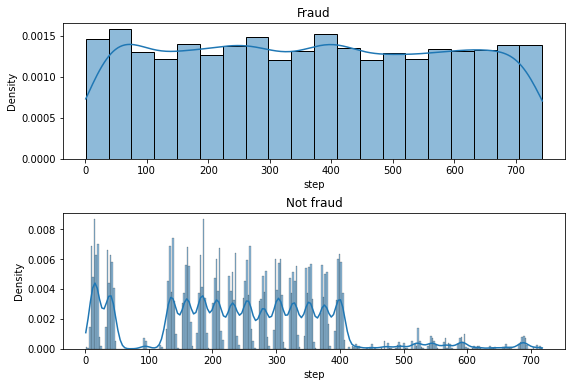

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
sns.histplot(fraud.step, kde=True, stat='density', ax=axes[0])
sns.histplot(not_fraud.step, kde=True, stat='density', ax=axes[1])
axes[0].set_title('Fraud')
axes[1].set_title('Not fraud')
plt.subplots_adjust(hspace=0.4)
plt.show()

The difference between valid and fraudulent transactions is clearly visible. Fraudulent transactions are evenly distributed throughout all steps, as opposed to valid ones. 
Let's look at the distribution by hours for days.

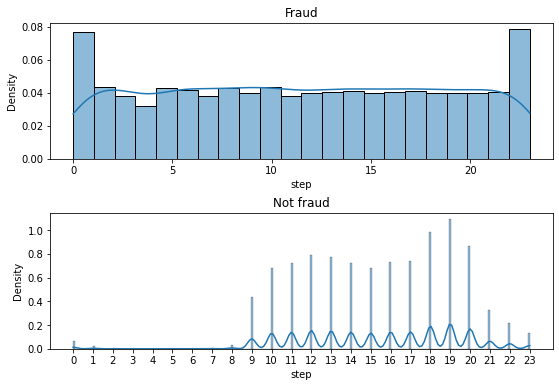

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
sns.histplot(fraud.step % 24, kde=True, stat='density', ax=axes[0])
sns.histplot(not_fraud.step % 24, kde=True, stat='density', ax=axes[1])
axes[0].set_title('Fraud')
axes[1].set_title('Not fraud')
axes[1].set_xticks(range(24))
plt.subplots_adjust(hspace=0.4)
plt.show()

Again, we can clearly see the subsidence of valid transactions. The subsidence occurs in the first 8 hours, while fraudulent transactions occur evenly throughout the day.

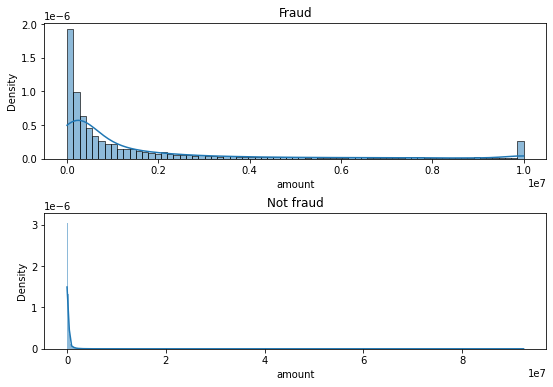

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 6))
sns.histplot(fraud.amount, kde=True, stat='density', ax=axes[0])
sns.histplot(not_fraud.amount, kde=True, stat='density', ax=axes[1])
axes[0].set_title('Fraud')
axes[1].set_title('Not fraud')
plt.subplots_adjust(hspace=0.4)
plt.show()

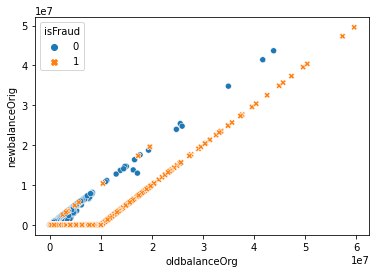

In [ ]:
sns.scatterplot(data=new_df, x='oldbalanceOrg', y='newbalanceOrig', hue='isFraud', style='isFraud')
plt.show()

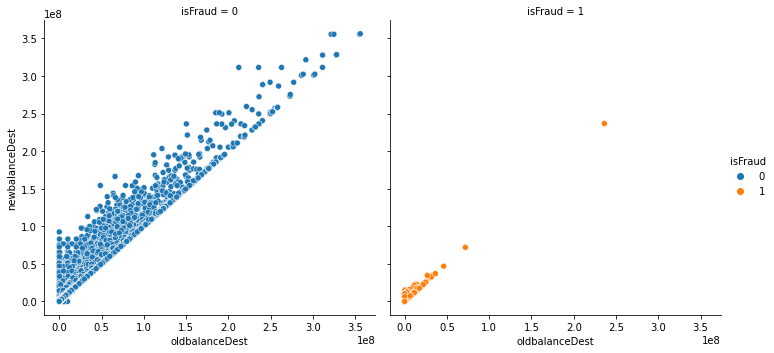

In [ ]:
sns.relplot(
    data=new_df, x='oldbalanceDest', y='newbalanceDest',
    col='isFraud', hue='isFraud', 
    kind='scatter')
plt.show()

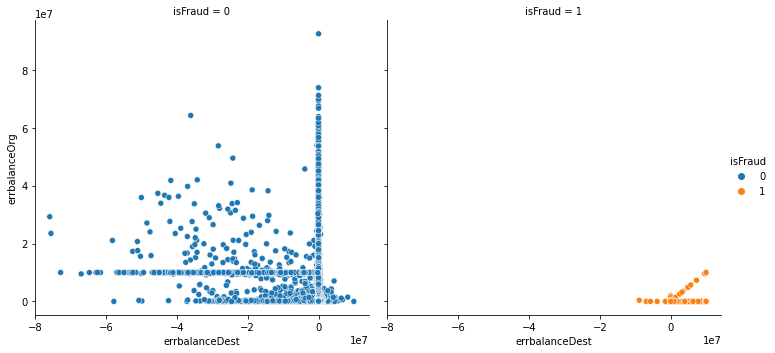

In [ ]:
sns.relplot(
    data=new_df, x='errbalanceDest', y='errbalanceOrg',
    col='isFraud', hue='isFraud', 
    kind='scatter')
plt.show()

We can clearly see that our functions are likely to effectively detect fraudulent transactions. Therefore, let's move on to data preprocessing. We replace the categorical variable with numeric ones, divide the data into training and test samples and normalize them for greater efficiency of machine learning models.

In [ ]:
ohe = OneHotEncoder(sparse=False)

new_df[['typeCASH_OUT', 'typeTRANSFER']] = ohe.fit_transform(new_df.type.values.reshape(-1, 1))

new_df = new_df.drop('type', axis=1)
new_df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,errbalanceOrg,errbalanceDest,typeCASH_OUT,typeTRANSFER
2,1,181.00,181.0,0.0,-1.0,-1.00,1,0.00,181.0,0.0,1.0
3,1,181.00,181.0,0.0,21182.0,0.00,1,0.00,21363.0,1.0,0.0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,213808.94,182703.5,1.0,0.0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,214605.30,237735.3,0.0,1.0
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,300850.89,-2401220.0,0.0,1.0


In [ ]:
X = new_df.drop('isFraud', axis=1)
y = new_df.isFraud
Sc = StandardScaler()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=False)
X_train = Sc.fit_transform(X_train)
X_test = Sc.transform(X_test)

Note that I am using the shuffle = False parameter because I assume the model should predict the future from the past, and to avoid the possibility of knowing the future while training models.

Now let us go directly to the choice of the model. Since the data is highly imbalanced, I'll take precision, recall and AURPC as metrics. I will also take into account the Matthews correlation coefficient as the most informative balanced indicator.

I also assume that false positive results are higher than false negative results for financial losses, so in that case I will give preference to algorithms with a lower FP result

First, let's select several algorithms and see how they cope with intuitively selected parameters.

In [ ]:
names = ['Logistic Regression', 'Random Forest', 
         'Ada Boost', 'Bagging Classifier',
         'Cat Boost', 'LGBM Classifier', 'XGB Classifier']

classifiers = [
    LogisticRegression(class_weight='balanced', n_jobs=-1, random_state=42),
    RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42),
    AdaBoostClassifier(random_state=42),
    BaggingClassifier(n_jobs=-1, random_state=42),
    CatBoostClassifier(n_estimators=100, max_depth=3, auto_class_weights='Balanced', random_state=42, verbose=False),
    LGBMClassifier(n_estimators=100, max_depth=3, class_weight='balanced', n_jobs=-1, random_state=42),
    XGBClassifier(n_estimators=100, max_depth=3, scale_pos_weight=((y == 0).sum() / (y == 1).sum()), n_jobs=-1, random_state=42)]

def result(clf, name, x_test, y_test):
    y_prob=clf.predict_proba(x_test)
    y_pred=clf.predict(x_test)
    print('The model used :', name) 
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('The accuracy :', accuracy_score(y_test, y_pred))
    print('The precision :', precision_score(y_test, y_pred)) 
    print('The recall :', recall_score(y_test, y_pred))
    print('F1 - score :', f1_score(y_test, y_pred))
    print('The Matthews correlation coefficient :', matthews_corrcoef(y_test, y_pred)) 
    print('Confusion_matrix :')
    print(confusion_matrix(y_test, y_pred))

In [ ]:
for name, classifier in zip(names, classifiers):
    start = time.time()
    classifier.fit(X_train, y_train)
    result(classifier, name, x_test=X_test, y_test=y_test)
    print('Duration : {} seconds'.format(round(time.time() - start, 2)))
    print('_' * 60)
    

The model used : Logistic Regression
AUPRC : 0.6509798344201101
The accuracy : 0.9744102993212905
The precision : 0.14910132258186065
The recall : 0.829559748427673
F1 - score : 0.2527707687885273
The Matthews correlation coefficient : 0.34532485776449073
Confusion_matrix :
[[886883  22582]
 [   813   3957]]
Duration : 22.93 seconds
____________________________________________________________
The model used : Random Forest
AUPRC : 0.9999997802569814
The accuracy : 0.9999967185679831
The precision : 0.9997903124344726
The recall : 0.99958071278826
F1 - score : 0.9996855016249083
The Matthews correlation coefficient : 0.999683857855516
Confusion_matrix :
[[909464      1]
 [     2   4768]]
Duration : 289.07 seconds
____________________________________________________________
The model used : Ada Boost
AUPRC : 0.9994208056889989
The accuracy : 0.9987486805908765
The precision : 1.0
The recall : 0.760167714884696
F1 - score : 0.8637446403049072
The Matthews correlation coefficient : 0.87132

As seen above, RF, XGBoost, Bagging, and LightGBM did the best. Let's dwell on them and try to improve the obtained results.

First in the queue is the potentially fastest model - LGBM

In [ ]:
%%time
# Let's try to increase a boosted trees
lgbm = LGBMClassifier(n_estimators=200, max_depth=3, class_weight='balanced', n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)
result(lgbm, name='LGBM Classifier', x_test=X_test, y_test=y_test)

The model used : LGBM Classifier
AUPRC : 0.9999316860474609
The accuracy : 0.9999978123786554
The precision : 0.9997903563941299
The recall : 0.9997903563941299
F1 - score : 0.9997903563941299
The Matthews correlation coefficient : 0.9997892568465938
Confusion_matrix :
[[909464      1]
 [     1   4769]]
CPU times: user 1min 6s, sys: 66 ms, total: 1min 6s
Wall time: 35.3 s


In [ ]:
%%time
# Let's try to increase a maximum depth
lgbm = LGBMClassifier(n_estimators=200, max_depth=5, class_weight='balanced', n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)
result(lgbm, name='LGBM Classifier', x_test=X_test, y_test=y_test)

The model used : LGBM Classifier
AUPRC : 0.9997408007816904
The accuracy : 0.9999967185679831
The precision : 0.9997903124344726
The recall : 0.99958071278826
F1 - score : 0.9996855016249083
The Matthews correlation coefficient : 0.999683857855516
Confusion_matrix :
[[909464      1]
 [     2   4768]]
CPU times: user 1min 26s, sys: 91.7 ms, total: 1min 26s
Wall time: 45.5 s


After going through several parameters, we achieved a fairly good result with 200 boosted trees and a maximum depth of 3.
Let's see what features were the most important

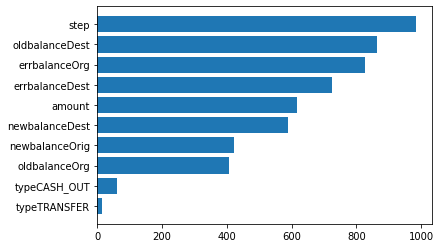

In [ ]:
importance_scores = lgbm.feature_importances_
temp = np.argsort(importance_scores)
plt.barh(X.columns[temp], importance_scores[temp])
plt.show()


The graph shows that the balance-error features created earlier turned out to be quite important.

Let's see if we can improve the result with XGBoost

In [ ]:
%%time
# Let's try parameters like LGBM
weight = ((y == 0).sum() / (y == 1).sum())
xgb = XGBClassifier(n_estimators=200, max_depth=3, scale_pos_weight=weight, n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)
result(xgb, name='XGB Classifier', x_test=X_test, y_test=y_test)

The model used : XGB Classifier
AUPRC : 0.9998753829893249
The accuracy : 0.9999978123786554
The precision : 0.9997903563941299
The recall : 0.9997903563941299
F1 - score : 0.9997903563941299
The Matthews correlation coefficient : 0.9997892568465938
Confusion_matrix :
[[909464      1]
 [     1   4769]]
CPU times: user 9min 46s, sys: 461 ms, total: 9min 46s
Wall time: 5min


In [ ]:
%%time
# Let's try to increase a maximum depth
xgb = XGBClassifier(n_estimators=200, max_depth=7, scale_pos_weight=weight, n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)
result(xgb, name='XGB Classifier', x_test=X_test, y_test=y_test)

The model used : XGB Classifier
AUPRC : 0.9999894224292579
The accuracy : 0.9999989061893277
The precision : 0.9997904003353595
The recall : 1.0
F1 - score : 0.9998951891835237
The Matthews correlation coefficient : 0.9998946449593018
Confusion_matrix :
[[909464      1]
 [     0   4770]]
CPU times: user 20min 58s, sys: 591 ms, total: 20min 58s
Wall time: 10min 41s


We managed to get a better result, but it takes longer than LGBM with comparable quality.

Let's try to change the test size and see the results.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, shuffle=False)
X_train = Sc.fit_transform(X_train)
X_test = Sc.transform(X_test)

In [ ]:
%%time
lgbm = LGBMClassifier(n_estimators=200, max_depth=3, class_weight='balanced', n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)
result(lgbm, name='LGBM Classifier', x_test=X_test, y_test=y_test)

The model used : LGBM Classifier
AUPRC : 0.999660140800505
The accuracy : 0.9999704014929198
The precision : 0.9933656087502242
The recall : 0.9992784992784993
F1 - score : 0.99631328117975
The Matthews correlation coefficient : 0.9963028441815789
Confusion_matrix :
[[1379624      37]
 [      4    5540]]
CPU times: user 1min 3s, sys: 81.7 ms, total: 1min 3s
Wall time: 34.8 s


In [ ]:
%%time
weight = ((y == 0).sum() / (y == 1).sum())
xgb = XGBClassifier(n_estimators=200, max_depth=7, scale_pos_weight=weight, n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)
result(xgb, name='XGB Classifier',x_test=X_test, y_test=y_test)

The model used : XGB Classifier
AUPRC : 0.9998024795096024
The accuracy : 0.9999935027667385
The precision : 0.9996389239935006
The recall : 0.9987373737373737
F1 - score : 0.9991879455021203
The Matthews correlation coefficient : 0.999184786337675
Confusion_matrix :
[[1379659       2]
 [      7    5537]]
CPU times: user 15min 25s, sys: 472 ms, total: 15min 25s
Wall time: 7min 51s


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)
X_train = Sc.fit_transform(X_train)
X_test = Sc.transform(X_test)

In [ ]:
%%time
lgbm = LGBMClassifier(n_estimators=200, max_depth=3, class_weight='balanced', n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)
result(lgbm, name='LGBM Classifier', x_test=X_test, y_test=y_test)

The model used : LGBM Classifier
AUPRC : 0.999867098784605
The accuracy : 0.9999927808519317
The precision : 0.9988090512107979
The recall : 0.9996027016289233
F1 - score : 0.9992057188244639
The Matthews correlation coefficient : 0.99920217229108
Confusion_matrix :
[[1103124       6]
 [      2    5032]]
CPU times: user 1min 5s, sys: 80.8 ms, total: 1min 5s
Wall time: 35.3 s


In [ ]:
%%time
lgbm = LGBMClassifier(n_estimators=400, max_depth=7, class_weight='balanced', n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)
result(lgbm, name='LGBM Classifier', x_test=X_test, y_test=y_test)

The model used : LGBM Classifier
AUPRC : 0.9999701546076585
The accuracy : 0.9999972928194744
The precision : 0.9998013113451222
The recall : 0.9996027016289233
F1 - score : 0.9997019966226283
The Matthews correlation coefficient : 0.9997006418333539
Confusion_matrix :
[[1103129       1]
 [      2    5032]]
CPU times: user 3min 9s, sys: 222 ms, total: 3min 10s
Wall time: 1min 39s


In [ ]:
%%time
xgb = XGBClassifier(n_estimators=200, max_depth=7, scale_pos_weight=weight, n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)
result(xgb, name='XGB Classifier',x_test=X_test, y_test=y_test)

The model used : XGB Classifier
AUPRC : 0.9999866046121644
The accuracy : 0.9999990976064914
The precision : 1.0
The recall : 0.9998013508144616
F1 - score : 0.9999006655408761
The Matthews correlation coefficient : 0.9999002172636473
Confusion_matrix :
[[1103130       0]
 [      1    5033]]
CPU times: user 19min 59s, sys: 587 ms, total: 19min 59s
Wall time: 10min 11s



Because earlier I assumed that the loss of funds is stronger with FP than with FN, we managed to get a slightly better result for XGB with test_size = 0.4, n_estimators = 200, max_depth = 7. However, the training of this model is heavily time consuming. That's why XGB is discarded.

Now let's look at a random forest

In [ ]:
%%time
rf =  RandomForestClassifier(n_jobs = -1, random_state=42)
rf.fit(X_train, y_train)
result(rf, name='Random Forest Classidie', x_test=X_test, y_test=y_test)

The model used : Random Forest Classidie
AUPRC : 0.9999998028178297
The accuracy : 0.9999981952129829
The precision : 0.9998013508144616
The recall : 0.9998013508144616
F1 - score : 0.9998013508144616
The Matthews correlation coefficient : 0.9998004443029898
Confusion_matrix :
[[1103129       1]
 [      1    5033]]
CPU times: user 11min 42s, sys: 727 ms, total: 11min 42s
Wall time: 5min 58s


In [ ]:
%%time
rf =  RandomForestClassifier(class_weight="balanced", n_jobs = -1, random_state=42)
rf.fit(X_train, y_train)
result(rf, name='Random Forest Classidie', x_test=X_test, y_test=y_test)

The model used : Random Forest Classidie
AUPRC : 0.9999998421775073
The accuracy : 0.9999981952129829
The precision : 0.9998013508144616
The recall : 0.9998013508144616
F1 - score : 0.9998013508144616
The Matthews correlation coefficient : 0.9998004443029898
Confusion_matrix :
[[1103129       1]
 [      1    5033]]
CPU times: user 8min 38s, sys: 715 ms, total: 8min 38s
Wall time: 4min 27s


The quality of random forest is comparable to LGBM, but it is also slower than LGBM, just as XGB. So, the random forest is also discarded.

Looking at BaggingClassifier

In [ ]:
%%time
bc = BaggingClassifier(n_jobs=-1, random_state=42)
bc.fit(X_train, y_train)
result(bc, name='Bagging Classifier', x_test=X_test, y_test=y_test)

The model used : Bagging Classifier
AUPRC : 0.9998006407735722
The accuracy : 0.9999981952129829
The precision : 0.9998013508144616
The recall : 0.9998013508144616
F1 - score : 0.9998013508144616
The Matthews correlation coefficient : 0.9998004443029898
Confusion_matrix :
[[1103129       1]
 [      1    5033]]
CPU times: user 3.87 s, sys: 537 ms, total: 4.4 s
Wall time: 1min 43s


In [ ]:
%%time
# Let's try to increase a decision trees in the ensemble
bc = BaggingClassifier(n_estimators=100, n_jobs=-1, random_state=42)
bc.fit(X_train, y_train)
result(bc, name='Bagging Classifier', x_test=X_test, y_test=y_test)

The model used : Bagging Classifier
AUPRC : 0.9998008771511446
The accuracy : 0.9999990976064914
The precision : 0.9998013902681231
The recall : 1.0
F1 - score : 0.9999006852716258
The Matthews correlation coefficient : 0.9999002369920177
Confusion_matrix :
[[1103129       1]
 [      0    5034]]
CPU times: user 4.08 s, sys: 225 ms, total: 4.3 s
Wall time: 15min 32s


In [ ]:
%%time
# Let's try to decrease a decision trees in the ensemble and number of features in each base estimator
bc = BaggingClassifier(n_estimators=5, max_features=0.5, n_jobs=-1, random_state=42)
bc.fit(X_train, y_train)
result(bc, name='Bagging Classifier', x_test=X_test, y_test=y_test)

The model used : Bagging Classifier
AUPRC : 0.99989873432761
The accuracy : 0.9999990976064914
The precision : 0.9998013902681231
The recall : 1.0
F1 - score : 0.9999006852716258
The Matthews correlation coefficient : 0.9999002369920177
Confusion_matrix :
[[1103129       1]
 [      0    5034]]
CPU times: user 3.88 s, sys: 200 ms, total: 4.08 s
Wall time: 37.4 s


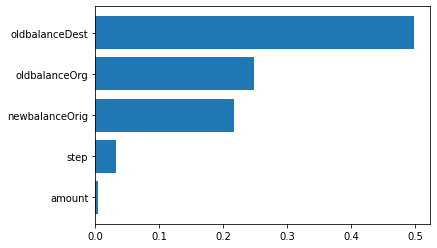

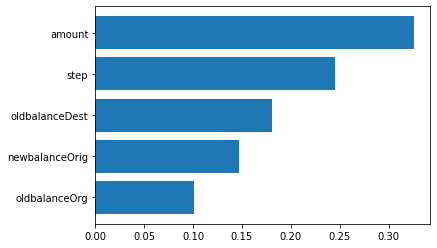

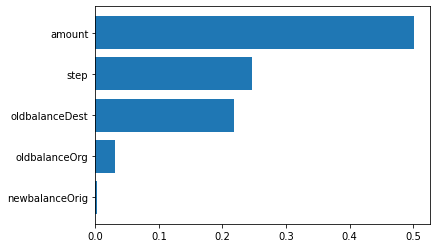

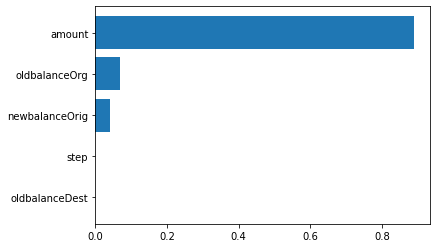

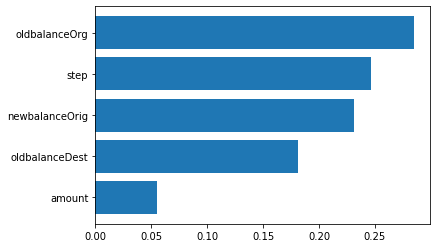

In [ ]:
for tree in bc.estimators_:
    importance_scores = tree.feature_importances_
    temp = np.argsort(importance_scores)
    plt.barh(X.columns[temp], importance_scores[temp])
    plt.show()

 
The Bagging Classifier demonstraited excellent results and turned out to be the best model in terms of the execution speed and quality.

# **Conclusion:**
A detailed research of the data made it possible to remove unnecessary features and add new useful ones.

The graphs showed that the resulting data set is able to separate fraudulent transactions from valid ones.

Focusing on FP and FN due to highly imbalanced data, and not being able to consult with people from business about possible losses due to incorrect predictions, it was assumed that the FP result would bring greater losses than FN. Therefore, with other metrics being alike, we choice the model with the lowest FP result. 

As expected, models based on an ensemble of decision trees performed great on unbalanced data. It was concluded that the Bagging Classifier had the best result at this stage.

# The best model was based on:

test_size=0.4 in train_test_split

n_estimators=5, max_features=0.5

# Result:

AUPRC : 0.99989873432761

The Matthews correlation coefficient : 0.9999002369920177

FP = 1, FN = 0

Elapsed time: ~39 sec


# Possible ways of improvement:

Consultations with people from business,

Oversampling and undersampling,

Stacking techniques,

Threshold for classifier.